# Deciphering Code with character-level RNNs
In this notebook, we'll look at how to build a recurrent neural network and train it to decipher strings encrypted with a certain cipher.
# Loading Dataset
The dataset we have consists of 10,000 encrypted phrases and the plaintext version of each encrypted phrase.

In [1]:
import os

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/deciphering-rnn/cipher.txt
/kaggle/input/deciphering-rnn/plaintext.txt


In [3]:
codes = load_data('../input/deciphering-rnn/cipher.txt')
plaintext = load_data('../input/deciphering-rnn/plaintext.txt')

In [4]:
codes[:5]

['YMJ QNRJ NX MJW QJFXY QNPJI KWZNY , GZY YMJ GFSFSF NX RD QJFXY QNPJI .',
 'MJ XFB F TQI DJQQTB YWZHP .',
 'NSINF NX WFNSD IZWNSL OZSJ , FSI NY NX XTRJYNRJX BFWR NS STAJRGJW .',
 'YMFY HFY BFX RD RTXY QTAJI FSNRFQ .',
 'MJ INXQNPJX LWFUJKWZNY , QNRJX , FSI QJRTSX .']

In [5]:
plaintext[:5]

['THE LIME IS HER LEAST LIKED FRUIT , BUT THE BANANA IS MY LEAST LIKED .',
 'HE SAW A OLD YELLOW TRUCK .',
 'INDIA IS RAINY DURING JUNE , AND IT IS SOMETIMES WARM IN NOVEMBER .',
 'THAT CAT WAS MY MOST LOVED ANIMAL .',
 'HE DISLIKES GRAPEFRUIT , LIMES , AND LEMONS .']

## Model Overview: Character-Level RNN
The model we will use here is a character-level RNN since the cipher seems to work on the characer level. In a machine translation scenario, a word-level RNN is the more common choice.

A character-level RNN will take as input an integer referring to a specific character and output another integer. To be able to get our model to work, we'll need to preprocess our dataset in the following steps:
 1. Isolating each character as an array element (instead of an entire phrase, or word being the element of the array)
 1. Tokenizing the characters so we can turn them from letters to integers and vice-versa
 1. Padding the strings so that all the inputs and outputs can fit in matrix form
 
To visualize this processing, let's assume either our source sequences (`codes` in this case) or target sequences (`plaintext` in this case) look like this (a list of strings):

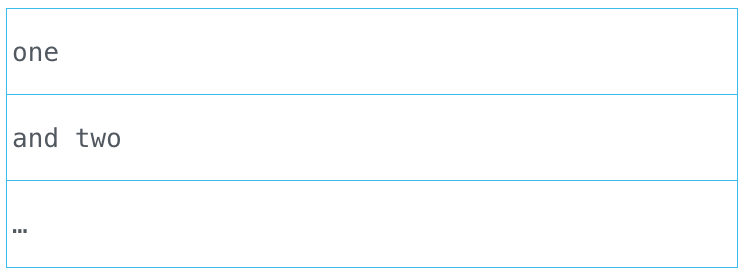

Since this model will be working on the character level, we'll need to separate each string into a list of characters (implicitly done by the tokenizer in this notebook):

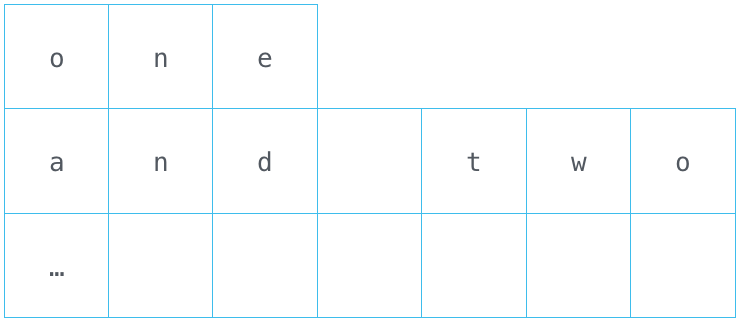

Then, the process of tokenization will turn each character into an integer.  Note that when you're working on the a word-level RNN (as in most machine translation examples), the tokenizer will assign an integer to each word rather than each letter, and each cell would represent a word rather than a character.

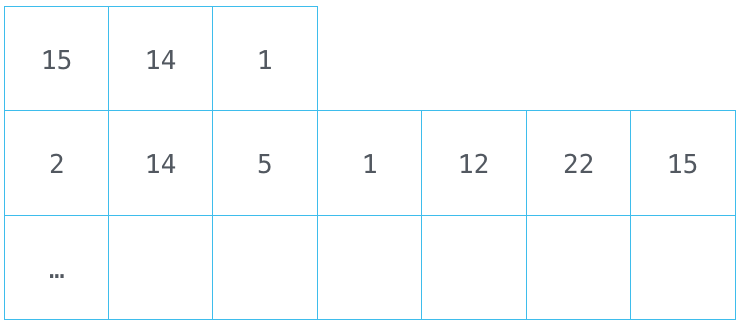

Most machine learning platforms expect the input to be a matrix rather than a list of lists. To turn the input into a matrix, we need to find the longest member of the list, and pad all shorter sequences with 0. Assuming 'and two' is the longest sequence in this example, the matrix ends up looking like this:

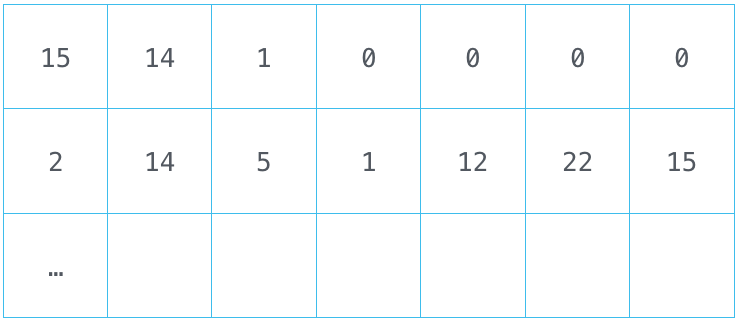

## Preprocessing
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Since we're working on the character level, make sure to set the `char_level` flag to the appropriate value. 

In [6]:
from keras.preprocessing.text import Tokenizer

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    x_tk = Tokenizer(char_level=True)
    x_tk.fit_on_texts(x)
    
    return x_tk.texts_to_sequences(x), x_tk

## Padding
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the cipher sequences have the same length and all the plaintext sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [7]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences


def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    # TODO: Implement
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen=length, padding='post')

## Preprocess Pipeline

In [8]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_code_sentences, preproc_plaintext_sentences, code_tokenizer, plaintext_tokenizer =\
    preprocess(codes, plaintext)

print('Data Preprocessed')

Data Preprocessed


In [9]:
preproc_code_sentences[0]

array([ 5, 14,  3,  1, 10,  2, 13,  3,  1,  2,  4,  1, 14,  3,  6,  1, 10,
        3,  8,  4,  5,  1, 10,  2, 25,  3, 11,  1, 20,  6,  9,  2,  5,  1,
       18,  1, 17,  9,  5,  1,  5, 14,  3,  1, 17,  8,  7,  8,  7,  8,  1,
        2,  4,  1, 13, 15,  1, 10,  3,  8,  4,  5,  1, 10,  2, 25,  3, 11,
        1, 19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [10]:
from keras.layers import GRU, Input, Dense, TimeDistributed
from keras.models import Model
from keras.layers import Activation
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy


def simple_model(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param code_vocab_size: Number of unique code characters in the dataset
    :param plaintext_vocab_size: Number of unique plaintext characters in the dataset
    :return: Keras model built, but not trained
    """
    # Build the layers
    learning_rate = 1e-3

    input_seq = Input(input_shape[1:])
    rnn = GRU(64, return_sequences=True)(input_seq)
    logits = TimeDistributed(Dense(plaintext_vocab_size))(rnn)

    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_code_sentences, preproc_plaintext_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_plaintext_sentences.shape[-2], 1))

In [11]:
# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)


In [12]:
simple_rnn_model.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=5, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 11s 42ms/step - loss: 1.5350 - accuracy: 0.5851 - val_loss: 0.8906 - val_accuracy: 0.7280
Epoch 2/5
250/250 [==============================] - 10s 41ms/step - loss: 0.6533 - accuracy: 0.8313 - val_loss: 0.4697 - val_accuracy: 0.8838
Epoch 3/5
250/250 [==============================] - 10s 42ms/step - loss: 0.3597 - accuracy: 0.9221 - val_loss: 0.2756 - val_accuracy: 0.9425
Epoch 4/5
250/250 [==============================] - 10s 41ms/step - loss: 0.2222 - accuracy: 0.9579 - val_loss: 0.1788 - val_accuracy: 0.9672
Epoch 5/5
250/250 [==============================] - 10s 41ms/step - loss: 0.1507 - accuracy: 0.9712 - val_loss: 0.1275 - val_accuracy: 0.9747


In [13]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], plaintext_tokenizer))

`logits_to_text` function loaded.
t h e   l i m e   i s   h e r   l e a s t   l i k e d   f r u i t   ,   b u t   t h e   b a n a n a   i s   m y   l e a s t   l i k e d   . <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [14]:
plaintext[0]

'THE LIME IS HER LEAST LIKED FRUIT , BUT THE BANANA IS MY LEAST LIKED .'